In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler

In [39]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


# Prepare Data

In [40]:
train = pd.read_csv("/content/drive/MyDrive/train.csv", index_col=[0])
test = pd.read_csv("/content/drive/MyDrive/test.csv", index_col=[0])

In [41]:
train.shape

(6036000, 7)

In [42]:
test.shape

(4024000, 6)

In [43]:
print(train.columns)

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [44]:
feature_cols = ["R","C", "u_in", "u_out"]

### Plot

In [45]:
# train[feature_cols+["pressure"]].hist(bins=10, figsize=(20,3), layout=(1,5))
# plt.show()

In [46]:
# idx = 1
# df_plot = train[train.breath_id==idx]

# plt.figure(figsize=(10,5))
# sns.lineplot(y=df_plot["u_in"], x=df_plot["time_step"])
# sns.lineplot(y=df_plot["u_out"], x=df_plot["time_step"])
# sns.lineplot(y=df_plot["pressure"], x=df_plot["time_step"])
# plt.legend(["u_in","u_out", "pressure"])
# plt.ylabel("")
# plt.xlabel("Time Steps")
# plt.show()

# Reshape to prepare them as Time Series

In [47]:
RS = RobustScaler()
train[feature_cols] = RS.fit_transform(train[feature_cols])
test[feature_cols] = RS.transform(test[feature_cols])

# Define Model

In [48]:
n_steps = 80
n_features = len(feature_cols)

In [49]:
print(train.columns)

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [50]:
train.shape

(6036000, 7)

In [51]:
print(train[feature_cols].values.size)

24144000


In [52]:
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_train = len(train) // n_steps  # Calculate the number of breaths
y_train = train[target_column_name].values[:n_samples_train * n_steps].reshape(-1, n_steps)
X_train = train[feature_cols].values[:n_samples_train * n_steps].reshape(-1, n_steps, n_features)

print(X_train.shape, y_train.shape)

(75450, 80, 4) (75450, 80)


In [53]:
def get_bigru_model():
    act = "swish"
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(n_steps, n_features)),
        layers.Bidirectional(layers.GRU(150, return_sequences=True)),
        layers.Bidirectional(layers.GRU(150, return_sequences=True)),
        layers.Bidirectional(layers.GRU(150, return_sequences=True)),
        layers.Bidirectional(layers.GRU(150, return_sequences=True)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation=act),
        layers.Dense(256, activation=act),
        layers.Dense(512, activation=act),
        layers.Dense(80)
    ])
    return model

bigru_model = get_bigru_model()
bigru_model.compile(optimizer="adam", loss="mae")

bigru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 80, 300)          140400    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 80, 300)          406800    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 80, 300)          406800    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 80, 300)          406800    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 80, 300)          

# Train Model

In [54]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1e4, decay_rate=1e-5)
cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = bigru_model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=512, callbacks=[cb_es, cb_lr])

Epoch 1/200
118/118 [==============================] - 47s 226ms/step - loss: 2.1557 - val_loss: 1.1984 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 24s 199ms/step - loss: 1.0859 - val_loss: 1.1387 - lr: 9.9885e-04
Epoch 3/200
118/118 [==============================] - 24s 205ms/step - loss: 0.9018 - val_loss: 1.0625 - lr: 9.9770e-04
Epoch 4/200
118/118 [==============================] - 25s 211ms/step - loss: 0.8171 - val_loss: 0.7468 - lr: 9.9655e-04
Epoch 5/200
118/118 [==============================] - 25s 215ms/step - loss: 0.7272 - val_loss: 0.6799 - lr: 9.9541e-04
Epoch 6/200
118/118 [==============================] - 25s 210ms/step - loss: 0.6591 - val_loss: 0.6205 - lr: 9.9426e-04
Epoch 7/200
118/118 [==============================] - 25s 211ms/step - loss: 0.6460 - val_loss: 0.6030 - lr: 9.9312e-04
Epoch 8/200
118/118 [==============================] - 25s 212ms/step - loss: 0.6014 - val_loss: 0.5540 - lr: 9.9197e-04
Epoch 9/200
118/118 [===============

# Plot Metrics

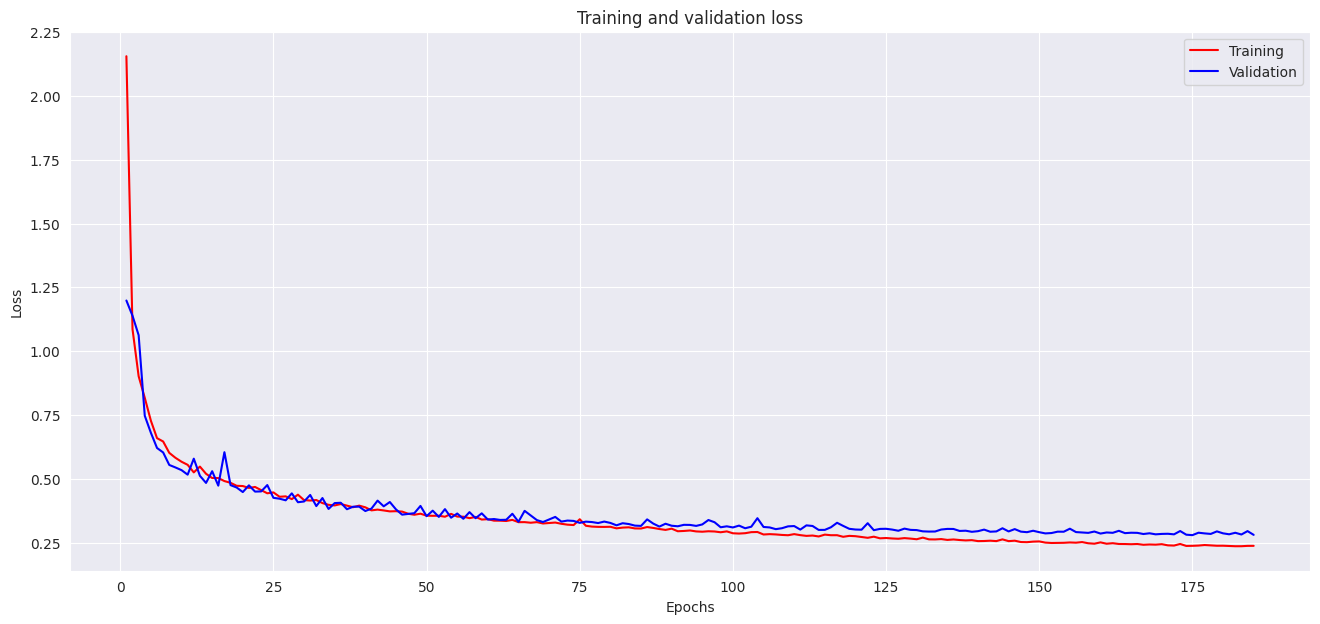

In [55]:
plt.figure(figsize=(16,7))
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation" ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')

plt.show()

# Plot

1/1 [==============================] - 3s 3s/step


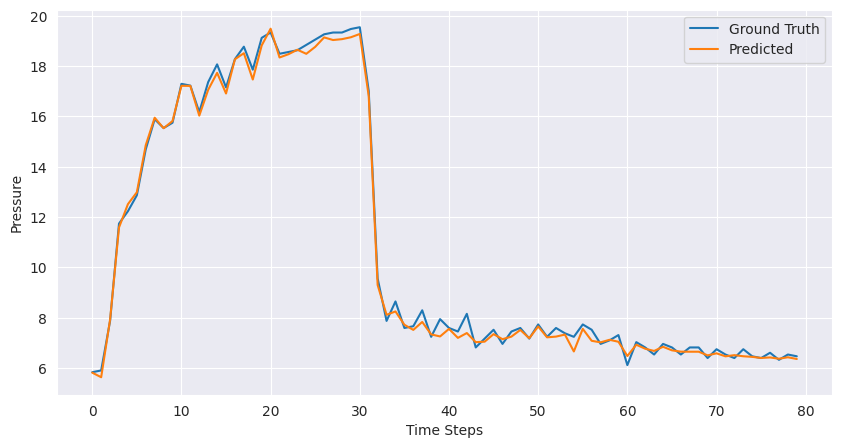

In [56]:
idx = 1
df_plot = train[train['breath_id'] == idx]
p = bigru_model.predict(df_plot[feature_cols].values.reshape(-1, n_steps, n_features))
x = range(len(df_plot))  # Use the length of df_plot for x values
y = df_plot['pressure']
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, label="Ground Truth")
sns.lineplot(x=x, y=p.reshape(-1), label="Predicted")
plt.legend()
plt.ylabel("Pressure")
plt.xlabel("Time Steps")
plt.show()